In [93]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import sqrt
from numpy import argmax

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [94]:
#loading the data
tdm=pd.read_csv('term-deposit-marketing-2020.csv')
tdm.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [95]:
tdm.shape #We have 40,000 rows and 14 columns.

(40000, 14)

In [96]:
tdm.info() #We have a mix of quantitative and categorical data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [97]:
tdm.isnull().sum() #No null/missing variables

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

<Axes: title={'center': 'Proportion of Clients who have subscribed to a Term Deposit'}, ylabel='count'>

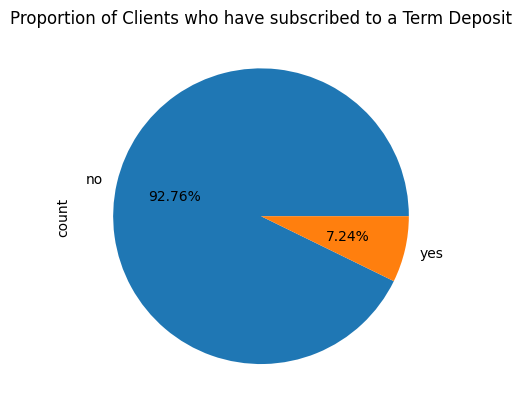

In [98]:
#Data Exploration
#Visualisation of target column relative frequency
tdm['y'].value_counts().plot(kind='pie',autopct='%1.2f%%',title='Proportion of Clients who have subscribed to a Term Deposit')
#Data highly unbalaced, will need to smooth


In [99]:
#Correlation between numerical variables
#First convert target variable to 0 and 1
tdm['y']=tdm['y'].map({'yes': 1, 'no': 0})
tdm.corr(numeric_only=True) #No multicollinearity amongst numerical variables and target


,age,balance,day,duration,campaign,y
age,1.000000,0.081517,-0.011689,-0.036270,0.016204,-0.020273
balance,0.081517,1.000000,0.011662,0.014072,-0.008137,0.030232
day,-0.011689,0.011662,1.000000,-0.032983,0.165429,-0.006420
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387,0.461169
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000,-0.040350
y,-0.020273,0.030232,-0.006420,0.461169,-0.040350,1.000000


<Axes: xlabel='age', ylabel='Density'>

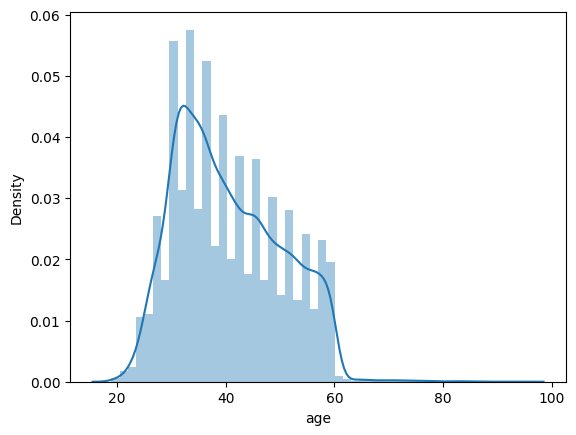

In [100]:
#We will now look at the different variables. First, looking at the age variable.
sns.distplot(tdm['age']) #The majority of the respondents are between the ages of 25 and 60.


<Axes: xlabel='job'>

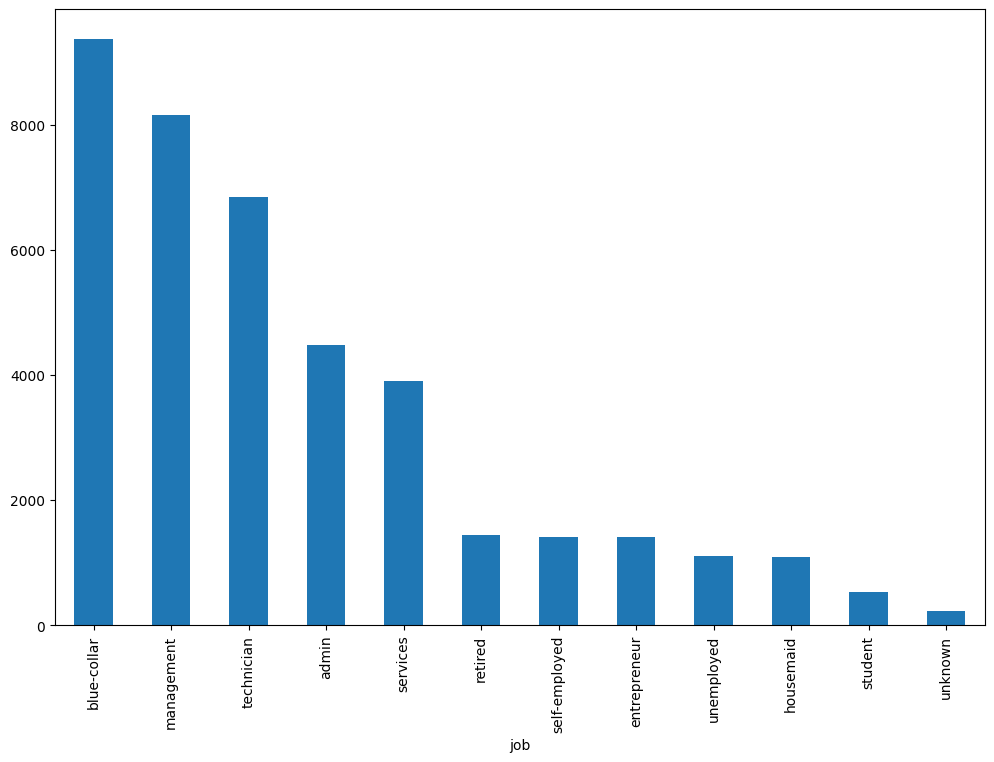

In [101]:
#First job
tdm['job'].value_counts()
tdm['job'].value_counts().plot(kind='bar', figsize=(12,8))

In [102]:
#Marital Status
tdm['marital'].value_counts() #The majority of respondents are married.

marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64

<Axes: xlabel='marital', ylabel='percent'>

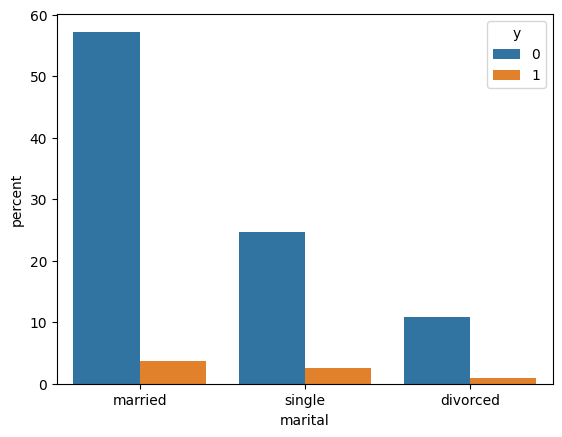

In [103]:
sns.countplot(data=tdm, x='marital', hue='y',stat="percent") #The proportion of 'yes' responses is very small for all marital statuses.

<Axes: xlabel='education', ylabel='percent'>

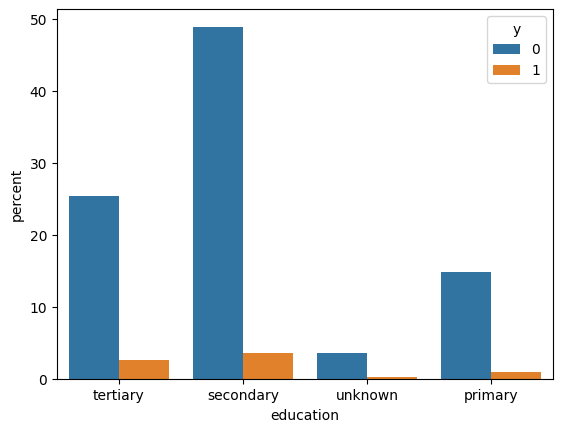

In [104]:
#Education
sns.countplot(data=tdm, x='education', hue='y',stat="percent") #Almost half of the respondents reached the secondary level of eduction.The proportion of 'yes' responses is very small for all education levels.

<Axes: xlabel='default', ylabel='percent'>

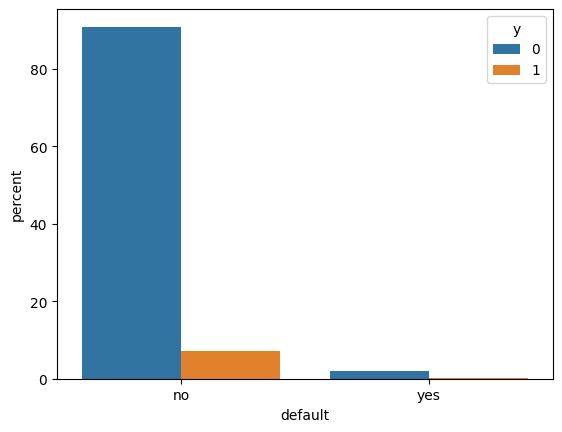

In [105]:
#Default
sns.countplot(data=tdm, x='default', hue='y',stat="percent") #80% of the respondents do not have creadit in default.

<Axes: xlabel='balance', ylabel='Density'>

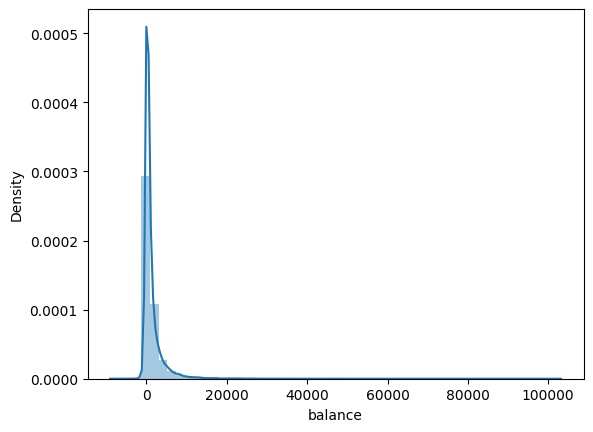

In [106]:
#Average yearly balance
sns.distplot(tdm['balance'])

<Axes: xlabel='housing', ylabel='percent'>

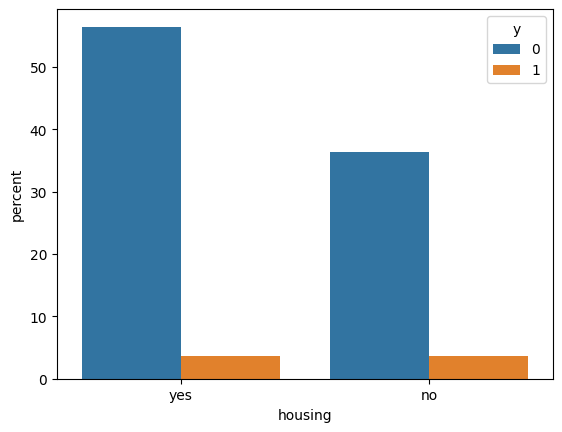

In [107]:
#Housing
sns.countplot(data=tdm, x='housing', hue='y',stat="percent") #Housing loan does not seem to impact the responses.

<Axes: xlabel='loan', ylabel='percent'>

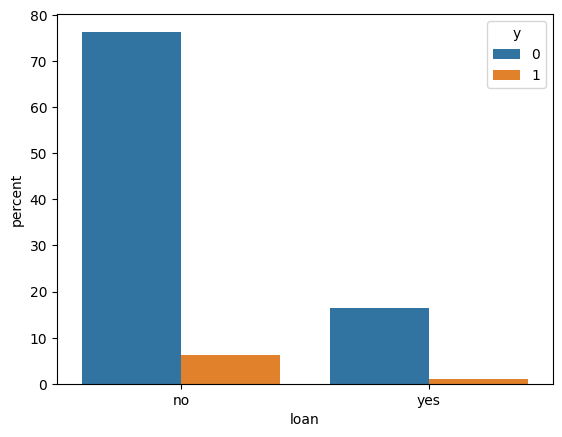

In [108]:
#Loan
sns.countplot(data=tdm, x='loan', hue='y',stat="percent") #Personal loan does not seem to impact the responses.

<Axes: xlabel='contact', ylabel='percent'>

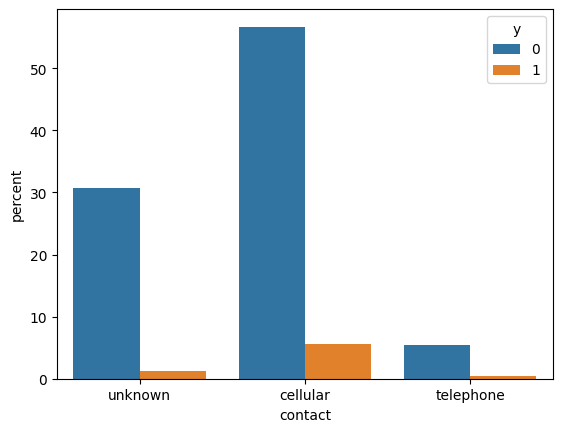

In [109]:
#Contact
sns.countplot(data=tdm, x='contact', hue='y',stat="percent") #Method of contact does not seem to impact the responses.

<Axes: xlabel='duration', ylabel='Density'>

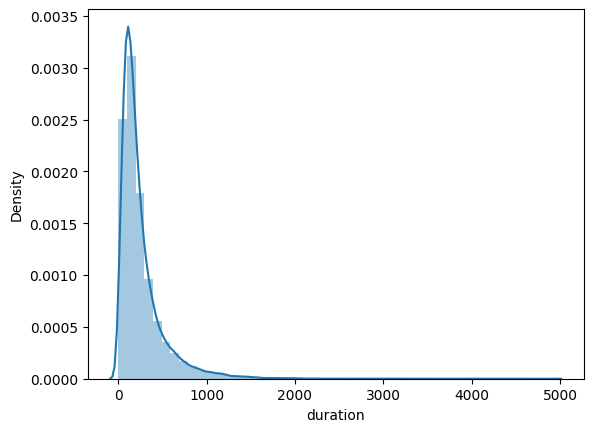

In [110]:
#Duration
sns.distplot(tdm['duration']) #Average duration is between 1 and 200.

<Axes: xlabel='campaign', ylabel='Density'>

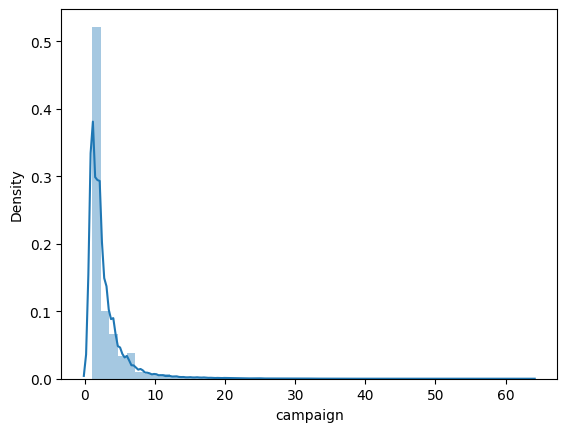

In [111]:
#Campaign
sns.distplot(tdm['campaign']) #1 contact during campaign has highest frequency.

In [112]:
#Data Modeling

#Importing "train_test-split" function to test the model
from sklearn.model_selection import train_test_split


In [113]:
#Splitting the data
X=tdm.drop(['y'],axis=1)
y=tdm['y']

In [114]:
#Model Comparison using automatic nested cross-validation
# Compare classification algorithms
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, balanced_accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [115]:
#We have two different data types: object and int64. Using Column Transformer with mixed type.
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)

In [116]:
#First let us set up using Logistic Regression
#Build the pipeline
from sklearn.pipeline import make_pipeline
#LogisticRegressionCV uses stratified K-fold by default, takes care of the imbalance
lg = make_pipeline(preprocessor, LogisticRegressionCV(cv=5, random_state=23,class_weight='balanced', scoring='accuracy',max_iter=4000))
#Fitting the model on the train data
lg.fit(X_train, y_train)
lg_score=cross_val_score(lg,X_train, y_train, cv=5,scoring='balanced_accuracy')
print(f"Accuracy Score of Logistic Model: {lg_score.mean():.4f}")


Accuracy Score of Logistic Model: 0.8026


In [117]:
#Random Forest Classifier
#Build the pipeline
rf = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced',random_state=42))
#Fitting the model on the train data
rf.fit(X_train, y_train)
rf_score=cross_val_score(rf,X_train, y_train, cv=5,scoring='balanced_accuracy')
print(f"Accuracy Score of Random Forest Classifier: {rf_score.mean():.4f}")


Accuracy Score of Random Forest Classifier: 0.6075


In [118]:
#Naive Bayes
#Build the pipeline
from sklearn.naive_bayes import GaussianNB
nb = make_pipeline(preprocessor, GaussianNB())
#Fitting the model on the train data
nb.fit(X_train, y_train)
nb_score=cross_val_score(nb,X_train, y_train, cv=5,scoring='balanced_accuracy')
print(f"Accuracy Score for Naive Bayes: {nb_score.mean():.4f}")

Accuracy Score for Naive Bayes: 0.6687


In [119]:
#KNN
#Build the pipeline
from sklearn.neighbors import KNeighborsClassifier
knn = make_pipeline(preprocessor, KNeighborsClassifier())
#Fitting the model on the train data
knn.fit(X_train, y_train)
knn_score=cross_val_score(knn,X_train, y_train, cv=5,scoring='balanced_accuracy')
print(f"Accuracy Score for K-Nearest Neighbor: {knn_score.mean():.4f}")

Accuracy Score for K-Nearest Neighbor: 0.6372


In [120]:
#SVM
#Build the pipeline
svc = make_pipeline(preprocessor, SVC())
#Fitting the model on the train data
svc.fit(X_train, y_train)
svc_score=cross_val_score(svc,X_train, y_train, cv=5,scoring='balanced_accuracy')
print(f"Accuracy Score for SVC: {svc_score.mean():.4f}")

Accuracy Score for SVC: 0.6161


In [121]:
#Decision Tree
dt = make_pipeline(preprocessor, DecisionTreeClassifier())
#Fitting the model on the train data
dt.fit(X_train, y_train)
dt_score=cross_val_score(dt,X_train, y_train, cv=5,scoring='balanced_accuracy')
print(f"Accuracy Score for Decision Tree: {dt_score.mean():.4f}")

Accuracy Score for Decision Tree: 0.6914


In [122]:
#The model with the highest accuracy score is SVM with 0.9354. Let's predict on the test data using the SVM Model.
# Model performance on test data
svc_pred=svc.predict(X_test)
from sklearn import metrics
print(f"Accuracy Score for SVM: {metrics.balanced_accuracy_score(y_test,svc_pred):.4f}")


Accuracy Score for SVM: 0.6324


In [123]:
# Model performance on test data for Logistic Regression
lg_pred=lg.predict(X_test)  
print(f"Accuracy Score of Logistic Model: {metrics.balanced_accuracy_score(y_test,lg_pred):.4f}")

Accuracy Score of Logistic Model: 0.8160


In [124]:
#Customers who are more likely to buy?
#Features Importance
feat_importance=pd.DataFrame({"Feature":X_train.columns,"Importance":lg_pred.best_estimator.feature_importances_}).sort_values(by="Importance")
feat_importance

AttributeError: 'numpy.ndarray' object has no attribute 'best_estimator'